In [34]:
import os
import numpy as np
import pandas as pd
import sqlite3
import math
import sys
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from collections import OrderedDict as Odict
from astropy import time

import lsst.afw.geom as afwGeom
import lsst.afw.cameraGeom
import lsst.geom as geom
import lsst.afw.display as afwDisplay
from lsst.daf.persistence import Butler


from lsst.afw.geom import makeSkyWcs
from lsst.obs.lsst.imsim import ImsimMapper

from lsst.sims.utils import angularSeparation
from lsst.sims.utils import getRotSkyPos
from lsst.sims.catUtils import supernovae
from lsst.sims.catUtils.supernovae import SNObject
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
from lsst.sims.catUtils.dust import EBVbase
from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.BandpassDict import BandpassDict
from lsst.sims.photUtils.SignalToNoise import calcSNR_m5, calcMagError_m5
from lsst.sims.photUtils.PhotometricParameters import PhotometricParameters

sys.path.insert(0, '/global/homes/r/rhlozek/gcr-catalogs')
import GCRCatalogs

repo = '/global/cscratch1/sd/rearmstr/new_templates/diffim_template'
butler = Butler(repo)
diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
truth_lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')

In [22]:
# Defining the box from the truth catalog
tract = 4849
patch = (6, 6)

# Cut a piece of the sky from the relevant tract
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]

#patchpoly = tract_info.getPatchInfo(patch)
#bar = patchpoly.getOuterSkyPolygon(tract_info.getWcs())

tract_box = afwGeom.Box2D(tract_info.getBBox())
tract_pos_list = tract_box.getCorners()
wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)
print( 'boundaries for simulation tract:', min_ra, max_ra, min_dec, max_dec)
print('54.727761961404_52.93572544959448_-28.2276731919467_-29.78294629153197')


boundaries for simulation tract: 52.93572544959448 54.72776196140405 -29.78294629153197 -28.2276731919467
54.727761961404_52.93572544959448_-28.2276731919467_-29.78294629153197


In [20]:
area_cut = [f'ra > {min_ra}', f'ra < {max_ra}', f'dec > {min_dec}', f'dec < {max_dec}']
sn_cut = ['sn == 1']
all_cuts = area_cut + sn_cut
# getting info from the DC2 catalogs
columns = ['ra', 'dec', 'redshift', 'uniqueId', 'galaxy_id', 'sn']
truth_sne = pd.DataFrame(truth_cat.get_quantities(columns, filters=all_cuts))
i = 10
sn = truth_sne.iloc[i]
ra, dec = sn['ra'], sn['dec']
print(ra, dec)

# Match on RA, Dec
sn_position = SkyCoord(sn['ra'], sn['dec'], unit='deg')
#sn_t0 = sn['t0]
diaObject_cat = diaObject.get_quantities(['ra', 'dec', 'diaObjectId'])
diaObject_positions = SkyCoord(diaObject_cat['ra'], diaObject_cat['dec'], unit='deg')
print(diaObject_positions)
idx, sep2d, _ = sn_position.match_to_catalog_sky(diaObject_positions)
print(f'Index: {idx} is {sep2d.to(u.arcsec)[0]:0.6f} away')
diaObjectId = diaObject_cat['diaObjectId'][idx]

53.701363635233754 -28.612806935072744
<SkyCoord (ICRS): (ra, dec) in deg
    [(53.19006979, -28.42791565), (53.17706282, -28.42526992),
     (53.17008481, -28.41005509), ..., (52.99593198, -28.33793884),
     (53.00038471, -28.33280359), (53.07184798, -28.28804726)]>
Index: 8523 is 1692.539971 arcsec away


In [4]:
# Now we go to the supernova and lightcurves data base that we constructed from minion using 
# https://github.com/LSSTDESC/run2_diaproc/blob/master/sn_rectangle.py on the same coordinates

In [38]:
# SN visit table
visitab = pd.read_csv('../../dia_tables/catalogs+tables/full_t_visits_from_minion.csv')
#dest_lc_file = '../lightcurves/lightcurves_cat_rect_{}_{}_{}_{}.csv'
sntab = pd.read_csv('../../dia_tables/catalogs+tables/supernovae_cat_rect_54.727761961404_52.93572544959448_-28.2276731919467_-29.78294629153197.csv')
#dest_snfile = '../catalogs+tables/supernovae_cat_rect_{}_{}_{}_{}.csv'
snlc = pd.read_csv('../../dia_tables/lightcurves/lightcurves_cat_rect_54.727761961404_52.93572544959448_-28.2276731919467_-29.78294629153197.csv')


In [24]:
print(np.shape(visitab), np.shape(sntab), np.shape(snlc))

(1739, 19) (3176, 14) (1739, 19060)


In [30]:
#Let's look at the visit tables first
visitab[0:5]

# the SN table gives us the t0, magnitudes for the observations
sntab[0:5]

# while the SN LC table gives us the flux as a function of visits - each one in a new column
snlc[0:5]



,Unnamed: 0,mjd,filter,visitn,MS_9043_0_observable,MS_9043_0_observed,MS_9043_0_flux,MS_9043_0_fluxErr,MS_9043_0_mag,MS_9043_0_magErr,...,MS_9171_4169_flux,MS_9171_4169_fluxErr,MS_9171_4169_mag,MS_9171_4169_magErr,MS_9171_4170_observable,MS_9171_4170_observed,MS_9171_4170_flux,MS_9171_4170_fluxErr,MS_9171_4170_mag,MS_9171_4170_magErr
0,0,59580.139555,r,230,False,False,0.0,4.602539e-11,inf,inf,...,0.0,4.602539e-11,inf,inf,False,False,0.0,4.602539e-11,inf,inf
1,1,59580.139972,r,231,False,False,0.0,4.295465e-11,inf,inf,...,0.0,4.295465e-11,inf,inf,False,False,0.0,4.295465e-11,inf,inf
2,2,59580.140389,r,232,False,True,0.0,4.299422e-11,inf,inf,...,0.0,4.299422e-11,inf,inf,False,False,0.0,4.299422e-11,inf,inf
3,3,59580.140805,r,233,False,False,0.0,4.598472e-11,inf,inf,...,0.0,4.598472e-11,inf,inf,False,False,0.0,4.598472e-11,inf,inf
4,4,59580.141222,r,234,False,False,0.0,4.602759e-11,inf,inf,...,0.0,4.602759e-11,inf,inf,False,False,0.0,4.602759e-11,inf,inf


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'SNe peaked')

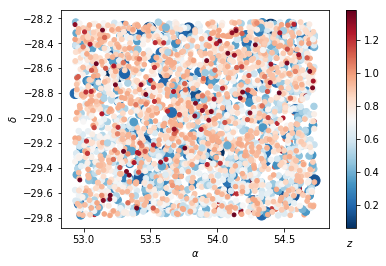

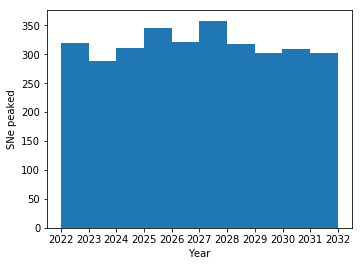

In [35]:
plt.scatter(sntab.snra_in, sntab.sndec_in, s=20/sntab.z_in, c=sntab.z_in, cmap='RdBu_r')
clb = plt.colorbar()
clb.set_label(r'$z$', labelpad=-30, y=-0.05, rotation=0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
t0 = time.Time(sntab.t0_in, format='mjd', scale='utc')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(t0.datetime64, cumulative=False)
plt.xlabel('Year')
plt.ylabel('SNe peaked')


In [ ]:
plt.plot()